# Loki
Disney+ TV Series Analysis

User: Jaime Avendaño

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from textblob import TextBlob
import sys
import tweepy
from collections import Counter

import html
import os
import nltk
#import pycountry
import re
import string
from wordcloud import WordCloud, STOPWORDS
from PIL import Image
from nltk.sentiment.vader import SentimentIntensityAnalyzer
#from langdetect import detect
from nltk.stem import SnowballStemmer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import CountVectorizer

In [3]:
consumer_key = os.environ.get('TWITTER_CONSUMER_KEY')
consumer_secret = os.environ.get('TWITTER_CONSUMER_SECRET')
access_token = os.environ.get('TWITTER_ACCESS_TOKEN')
access_token_secret = os.environ.get('TWITTER_ACCESS_TOKEN_SECRET')

In [4]:
assert consumer_key, 'Twitter consumer key wasn\'t found.'
assert consumer_secret, 'Twitter consumer secret wasn\'t found.'
assert access_token, 'Twitter access token wasn\'t found.'
assert access_token_secret, 'Twitter access token secret wasn\'t found.'

In [5]:
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth)
api

## Counter

In [11]:
results = tweepy.Cursor(api.search, q='#Loki -filter:retweets',
                        tweet_mode='extended', lang='en').items(100)

In [12]:
tweets_full = []

for tweet in results:
    tweets_full.append(tweet.full_text)
tweets_full[5]

'#Loki feeling a bit like #DoctorWho this week.'

In [13]:
tweets = []

[tweets.append(x) for x in tweets_full if x not in tweets]
len(tweets)

100

In [9]:
#nltk.download("stopwords")

In [14]:
words = []
stopwords = nltk.corpus.stopwords.words("english") + list(string.punctuation)

for t in tweets:
    for word in t.lower().split():
        if word not in stopwords:
            words.append(word)
        
c = Counter(words)
c.most_common(10)

[('#loki', 90),
 ('episode', 19),
 ('loki', 16),
 ('love', 16),
 ('#sylvie', 14),
 ('#lokiwednesdays', 12),
 ('#tomhiddleston', 7),
 ('like', 6),
 ('&amp;', 6),
 ('mobius', 6)]

## Sentiment Analysis 
Based on https://towardsdatascience.com/step-by-step-twitter-sentiment-analysis-in-python-d6f650ade58d

In [15]:
%%time
def percentage(part,whole):
    return 100 * float(part)/float(whole)


keyword = input('Please enter keyword or hashtag to search: ')
noOfTweet = int(input ('Please enter how many tweets to analyze: '))
tweets = tweepy.Cursor(api.search, q=(keyword + ' -filter:retweets'), 
                       tweet_mode='extended', lang='en').items(noOfTweet)

positive = 0
negative = 0
neutral = 0
polarity = 0
tweet_list = []
neutral_list = []
negative_list = []
positive_list = []
score_list = []
analyzer = SentimentIntensityAnalyzer()

for tweet in tweets:
    #print(tweet.text)
    tweet_list.append(tweet.full_text)

tweet_list = list(set(tweet_list))
unique_tweets = len(tweet_list)
    
for tweet_text in tweet_list:    
    analysis = TextBlob(tweet_text)
    score = analyzer.polarity_scores(tweet_text)
    score_list.append(score)
    neg = score['neg']
    neu = score['neu']
    pos = score['pos']
    comp = score['compound']
    polarity += analysis.sentiment.polarity

    if comp >= 0.05:
        positive_list.append(tweet_text)
        positive += 1
    elif comp <= -0.05:
        negative_list.append(tweet_text)
        negative += 1
    else:
        neutral_list.append(tweet_text)
        neutral += 1

positive_pct = percentage(positive, unique_tweets)
negative_pct = percentage(negative, unique_tweets)
neutral_pct = percentage(neutral, unique_tweets)
polarity_pct = percentage(polarity, unique_tweets)

print('')
print(f'There were {unique_tweets} unique tweets.\n')
print(f'{positive} Positive tweets = {positive_pct:.1f}%')
print(f'{negative} Negative tweets = {negative_pct:.1f}%')
print(f'{neutral} Neutral tweets = {neutral_pct:.1f}%')
print('')
print(f'Overall Polarity Sum = {polarity:.2f}%')

Please enter keyword or hashtag to search: #Loki
Please enter how many tweets to analyze: 250

There were 250 unique tweets.

131 Positive tweets = 52.4%
40 Negative tweets = 16.0%
79 Neutral tweets = 31.6%

Overall Polarity Sum = 37.16%
Wall time: 15.9 s


In [29]:
tweet_df = pd.DataFrame(tweet_list, columns=['text'])
tweet_df['text_clean'] = tweet_df['text'].str.lower()\
                                        .str.replace(r'https?:\/\/\S*', '', regex=True)\
                                        .str.replace('\n', ' ', regex=False)\
                                        .apply(html.unescape)
tweet_df['score'] = tweet_df['text_clean'].apply(lambda text: analyzer.polarity_scores(text))
tweet_df['neg'] = [score.get('neg') for score in tweet_df.score]
tweet_df['neu'] = [score.get('neu') for score in tweet_df.score]
tweet_df['pos'] = [score.get('pos') for score in tweet_df.score]
tweet_df['compound'] = [score.get('compound') for score in tweet_df.score]

tweet_df['sentiment'] = np.where(tweet_df.compound >= 0.05, 'Positive',
                                 np.where(tweet_df.compound <= -0.05, 'Negative',
                                          'Neutral'))
tweet_df.head()

,text,text_clean,score,neg,neu,pos,compound,sentiment
0,I love that they are drinking Josta. Can we br...,i love that they are drinking josta. can we br...,"{'neg': 0.0, 'neu': 0.76, 'pos': 0.24, 'compou...",0.0,0.760,0.240,0.6946,Positive
1,Holy shirt you’re telling me the entirety of t...,holy shirt you’re telling me the entirety of t...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0,1.000,0.000,0.0000,Neutral
2,#sylki Superiority #loki #Sylvie https://t.co/...,#sylki superiority #loki #sylvie,"{'neg': 0.0, 'neu': 0.556, 'pos': 0.444, 'comp...",0.0,0.556,0.444,0.3400,Positive
3,#sylvie and #loki had the SWEETEST most ROMANT...,#sylvie and #loki had the sweetest most romant...,"{'neg': 0.0, 'neu': 0.8, 'pos': 0.2, 'compound...",0.0,0.800,0.200,0.4576,Positive
4,Just a little Loki portrait in my new sketchbo...,just a little loki portrait in my new sketchbo...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0,1.000,0.000,0.0000,Neutral


In [32]:
tweet_df.sentiment.value_counts()

Positive    132
Neutral      79
Negative     39
Name: sentiment, dtype: int64

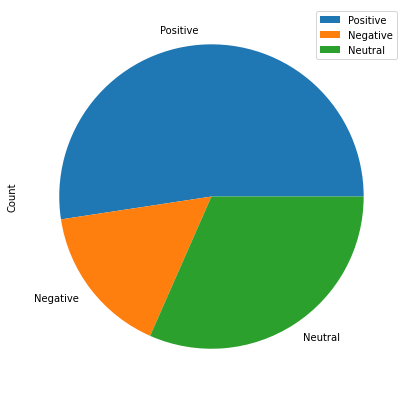

In [17]:
sentiment_df = pd.DataFrame({'Count': [positive, negative, neutral]},
                            index = ['Positive', 'Negative', 'Neutral'])
sentiment_df.plot.pie(y = 'Count', figsize=(7, 7));

In [33]:
def create_wordcloud(text):
    #mask = np.array(Image.open('cloud.png'))
    stopwords = set(STOPWORDS)
    wc = WordCloud(background_color='white',
                   #mask = mask,
                   max_words=3000,
                   stopwords=stopwords,
                   repeat=True)
    wc.generate(str(text))
    wc.to_file('wc.png')
    print('Word Cloud Saved Successfully')
    path='wc.png'
    display(Image.open(path))

Word Cloud Saved Successfully


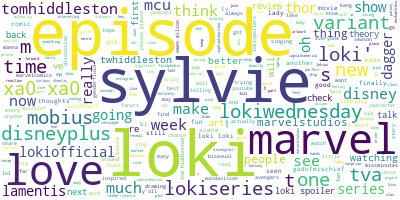

In [34]:
create_wordcloud(tweet_df['text_clean'].values)

In [44]:
tweet_df.text[tweet_df.sentiment == 'Negative'].values[10:20]

array(['All the time we have T-Shirt - https://t.co/iSwDex0EuL Miss Minutes T-Shirt for just $13! #Harebrained #Loki #LooneyTunes #MarvelComics #MissMinutes #Parody #ThatsAllFolks #TimeVarianceAuthority #TV #TVA https://t.co/2KptSs7L0J',
       "2 wks ago @jasonmylesclark was walking down the street &amp; the little black &amp; white furry guy he's holding followed him to his car. He was sick. We took him in, nursed him back to health &amp; now #Tuxedo has a brother! His name is #loki He's living up to his #Marvel inspired name.🐱🐱 https://t.co/iTjQO5qCtT",
       'There is no time keepers! Loki of a different universe is pulling the strings at the #TVA 🤔 #Loki',
       'We are loving #Loki, but is anyone else missing #WandaVision as much as we are ?? 😭❤️\u200d🔥 https://t.co/AMfCT047lu',
       "Notice some celebrating about #loki being bisexual.....umm how the hell is this new to them?! Read up in the Norse Mythology and the comics it's being always being there sorry entitled ones it's